In [7]:
import pandas as pd 
import math 
import matplotlib.pyplot as plt 
from scipy.integrate import solve_ivp
import pywt
import numpy as np
from scipy.optimize import curve_fit
import nolds


#Condense the code? Should take 30 minutes

In [3]:
def fhn(t, xy, z): #Function for the fitzhugh nagumo oscillatorpip
    alpha = 3
    w = 1
    a = 0.7
    b = 0.8
    x = xy[0]
    y = xy[1]
    dx = alpha * (y + x - (x**3)/3 + z) #creates a the derivative of x and y to be put in a matrix
    dy = (-1/alpha) * ((w**2) * x - a + b * y)
    return [dx, dy] #represents the system of equations for a FHN oscillator 

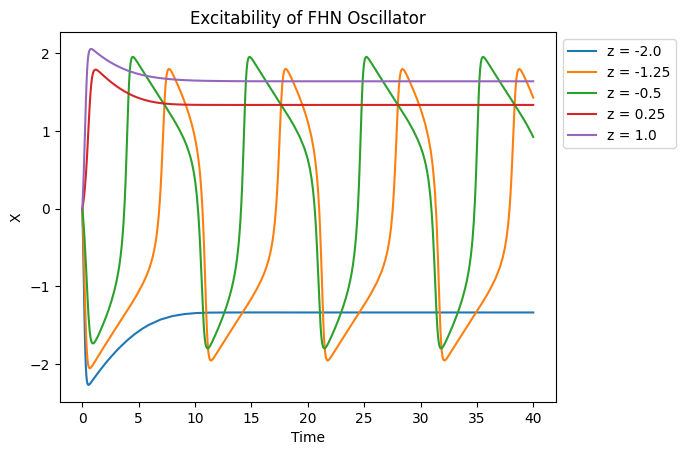

In [4]:
t_span = (0, 40) #for visualization of oscillator, keep it short 
y0 = [0, 0] #arbitrary initial conditions 
z_values = np.linspace(-2,1,5) #create 5 z values between -2 and 1 for visualization
plt.figure()
for i in range(len(z_values)): #for each z value, solve the system of differential equations using a solver based on the LSODA method 
    z = z_values[i]
    fhn_z = lambda t, xy: fhn(t, xy, z)
    sol = solve_ivp(fhn_z, t_span, y0, method='LSODA', dense_output=True) #LSODA designed for stiff equations
    xy = sol.y #get the solutions to the the differential system 
    t = sol.t #get the respective time points

    plt.plot(t, xy[0], label=f'z = {round(z, 2)}') #plot each Z values excitability (x) against time 
    
plt.xlabel('Time')
plt.ylabel('X')
plt.title('Excitability of FHN Oscillator')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

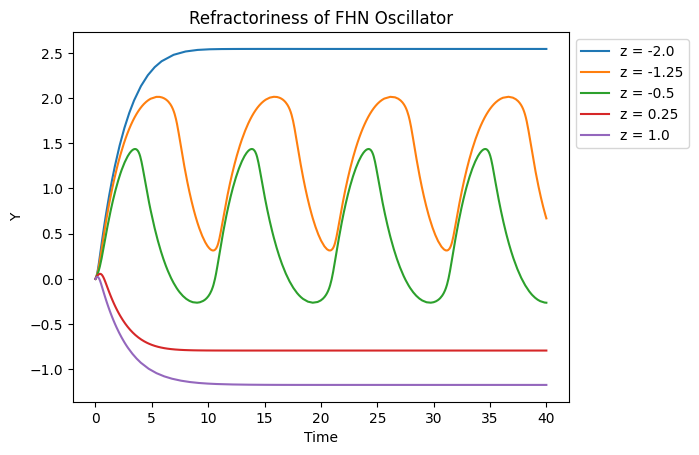

In [5]:
t_span = (0, 40) #Much like excitability code above, do the same for the refractoriness (y)
y0 = [0, 0]
z_values = np.linspace(-2,1,5)
plt.figure()
for i in range(len(z_values)):
    z = z_values[i]
    fhn_z = lambda t, xy: fhn(t, xy, z)
    sol = solve_ivp(fhn_z, t_span, y0, method='LSODA', dense_output=True)
    xy = sol.y
    t = sol.t 

    plt.plot(t, xy[1], label=f'z = {round(z, 2)}')
    
plt.xlabel('Time')
plt.ylabel('Y')
plt.title('Refractoriness of FHN Oscillator')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

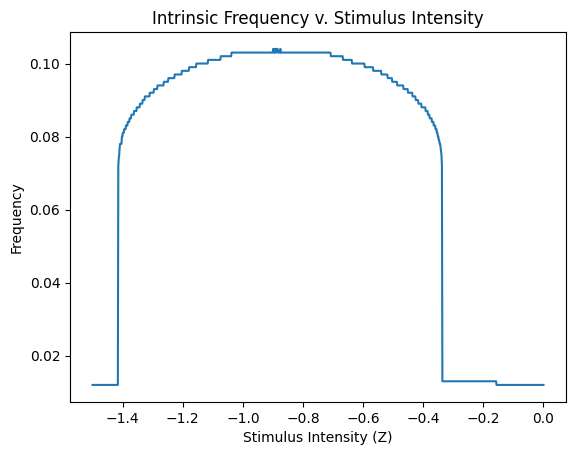

In [4]:
#Look further at y and its frequencies 

t_span = (0, 200) 
y0 = [0, 0]
z_values = np.linspace(-1.5,0,1000) #can make it larger for more fine results 
intrinsic_freq = [] #empty list to place the instrinsic frequencies extracted from each z value
frequencies = np.arange(0.01,1,0.001) #create frequencies to look at. Will expect something in between 0 and 1 Hz for neurons (tried 2, got similar results so condensed it)
scales = pywt.frequency2scale('cmor1.5-1.0', frequencies) #convert the frequency to scale for pywavelets function used later

for i in z_values:
    fhn_z = lambda t, xy: fhn(t, xy, i) 
    sol = solve_ivp(fhn_z, t_span, y0, method='LSODA', dense_output=True) #Solve the FHN oscillator
    t = np.linspace(t_span[0], t_span[1],200) #calculate the time values for calculating the x and y response of the oscillator 
    xy = sol.sol(t)
    x = xy[0] #extract the x value solutions 
    #utilize complex morlet wavelet transform for x solution and set scale
    coeffs,freqs = pywt.cwt(x, scales, 'cmor1.5-1.0') #retrieve the coefficients and the respective frequencies from the cwt
    idx = np.argmax(np.sum(np.abs(coeffs), axis=1)) #find the index where the sum of the absolute value of the coefficient in that row (frequency scale) is largest 
    dom_freq = freqs[idx] #find the frequency values for corresponding to the previous sum, this is the dominant or intrinsic freq
    intrinsic_freq.append(dom_freq) #add that freq to the empty list 
 
    
#Visualize and igure out exact zeros for determining k1 and k2 range 
plt.figure()
plt.plot(z_values, intrinsic_freq)
plt.xlabel('Stimulus Intensity (Z)')
plt.ylabel('Frequency')
plt.title('Intrinsic Frequency v. Stimulus Intensity')
plt.show()

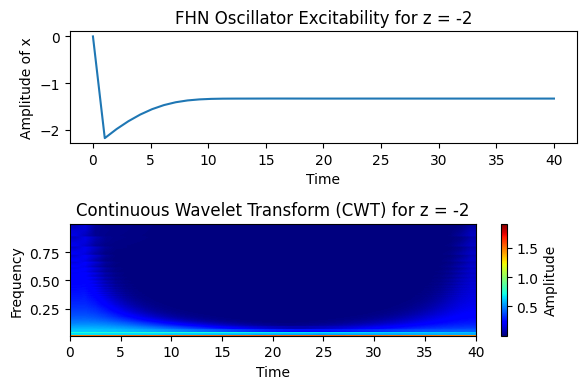

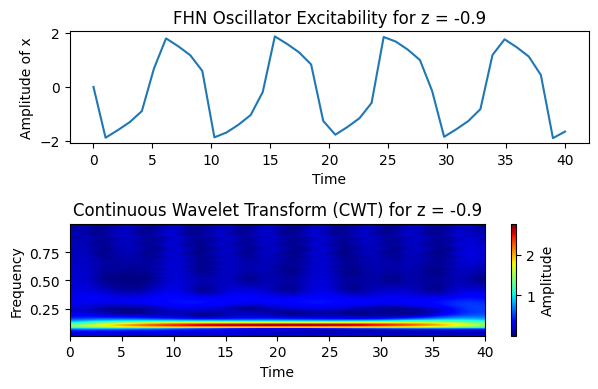

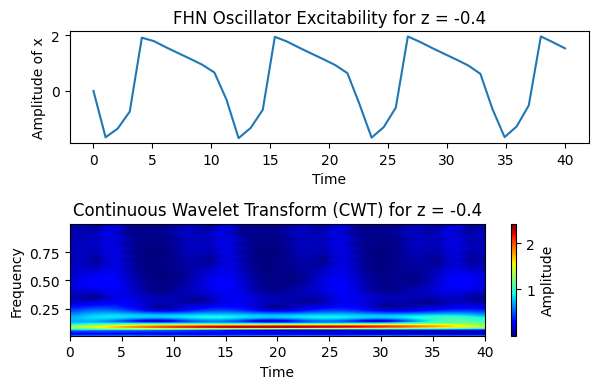

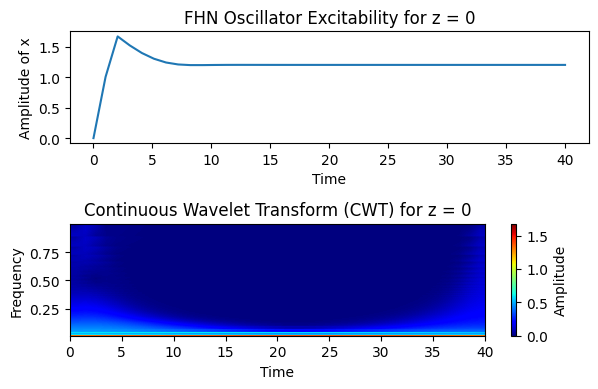

In [7]:
# Plots of spectrograms for visuals and validation of results 

t_span = (0, 40)
y0 = [0, 0]
frequencies = np.arange(0.01,1,0.001)
scales = pywt.frequency2scale('cmor1.5-1.0', frequencies)
z_values = [-2, -0.9, -0.4, 0] #only look at a few z values and plot the respective solutions
for i in z_values:
    z = i 
    fhn_z = lambda t, xy: fhn(t, xy, z)
    sol = solve_ivp(fhn_z, t_span, y0, method='LSODA', dense_output=True)

    t = np.linspace(t_span[0], t_span[1], 40)

    xy = sol.sol(t)
    x = xy[0]
    # Perform complex Morlet wavelet transform
    coeffs,freqs = pywt.cwt(x, scales, 'cmor1.5-1.0') 

    #plot the coefficients to the corresponding frequencies 
    plt.figure(figsize=(6, 4))

    plt.subplot(2, 1, 1)
    plt.plot(t, x)
    plt.title(f'FHN Oscillator Excitability for z = {z}')
    plt.xlabel('Time')
    plt.ylabel('Amplitude of x')

    plt.subplot(2, 1, 2)
    plt.imshow(np.abs(coeffs), aspect='auto', extent=[t.min(), t.max(), frequencies.min(), frequencies.max()],cmap='jet', interpolation='bilinear', origin='lower')
    plt.colorbar(label='Amplitude')
    plt.title(f'Continuous Wavelet Transform (CWT) for z = {z}')
    plt.xlabel('Time')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()



In [6]:
def fhn_coupled(t, xy, k1, k2, c): #Function for the fitzhugh nagumo oscillator
    alpha = 3
    w = 1
    a = 0.7
    b = 0.8
    x1 = xy[0]
    y1 = xy[1]
    x2 = xy[2]
    y2 = xy[3]
    coupled_oscillator = [alpha * (y1 + x1 - (x1**3)/3 + k1 + c*x2), #x1 equation
             (-1/alpha) * ((w**2) * x1 - a + b * y1), #y1 equation
             alpha * (y2 + x2 - (x2**3)/3 + k2 + c*x1), #x2 equation
             (-1/alpha) * ((w**2) * x2 - a + b * y2)] #y2 equation
    return coupled_oscillator

The highest coherence occurs at a symmetric coupling of 1.1717171717171717  and a stimulus intensity of  -0.29999999999999993 for the second oscillator


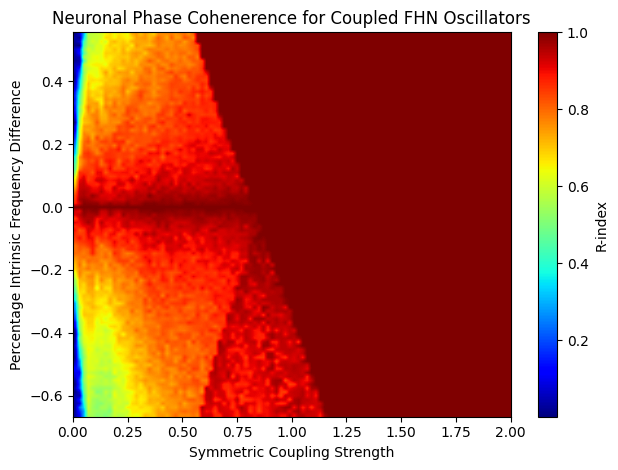

In [12]:

k_values = np.linspace(-1.4, -0.3, 100); #use 100 values between the set k value range 
c_values = np.linspace(0, 2, 100);#use 100 values for symmetric coupling, which is within the range of -1 (inhibitory), +1 (strongly coupled)
k1 = -0.9 #approximately the maximum k1 value
y_ax_list = []
t_span = (0, 100) #for final results, used a large t_span to observe any late changes in the oscillator dyanmics
y0 = [0, 0, 0, 0] #arbitrary intial conditions 
zeros = np.zeros((len(k_values),len(c_values)))#create an array of zeros for final results 
for k in k_values:
    k2 = k
    dk = k2 - k1
    y_ax_list.append(dk/k1) #calculate the y-axis values (intrinsic difference) with k1 remaining stable at the maximum intrinsic frequency 

y_ax_list.sort() #sort the y-axis from lowest to highest

for i in range(len(c_values)): #for loop embedded within a for loop 
    c = c_values[i] #select a c value, and for that c value loop through the y_axis values 
    for j in range(len(y_ax_list)): #of the form dk/k1 
        k = y_ax_list[j] #extract y_ax value and recalculate the k2
        k2 = k*k1 + k1
        #fhn_coupled = lambda t, xy: fhn_coupled(t, xy, k1, k2, c) 
        sol = solve_ivp(fhn_coupled, t_span, y0, method='LSODA', dense_output=True, args=(k1,k2,c)) #using k1,k2,c calculate the coupled system of nonlinear equations 
        #t = np.linspace(t_span[0], t_span[1], 1000)
        #xy = sol.sol(t)
        xy = sol.y
        dx1 = xy[0] #m with regards to the neuronal coherence index formula 
        dx2 = xy[2] #n with regards to the neuronal coherence index formula 
        phase_diff = np.angle(dx1) - np.angle(dx2) #extract the phase difference between the coupled excitability responses 
        r_index = np.abs(np.mean(np.exp(1j*phase_diff))) #calculate the r-index using the remainder of the formula
        zeros[j,i] = r_index #for the c value and intrinsic diff value, input the r-index score

#find the maximum coherence and coupling values 
max_index = np.unravel_index(np.argmax(zeros), zeros.shape)
max_row, max_col = max_index
max_c = c_values[max_col]
max_k2 = y_ax_list[max_row]*k1 +k1
print("The highest coherence occurs at a symmetric coupling of", max_c, " and a stimulus intensity of ", max_k2, "for the second oscillator")

#plot the R-index values as a spectrogram
plt.imshow(zeros, aspect='auto', extent=[c_values.min(), c_values.max(), min(y_ax_list), max(y_ax_list)],cmap='jet', interpolation='bilinear', origin='lower')
#potentially turn off interpolation
plt.colorbar(label='R-index')
plt.title(f'Neuronal Phase Cohenerence for Coupled FHN Oscillators')
plt.xlabel('Symmetric Coupling Strength')
plt.ylabel('Percentage Intrinsic Frequency Difference')
plt.tight_layout()
plt.show()


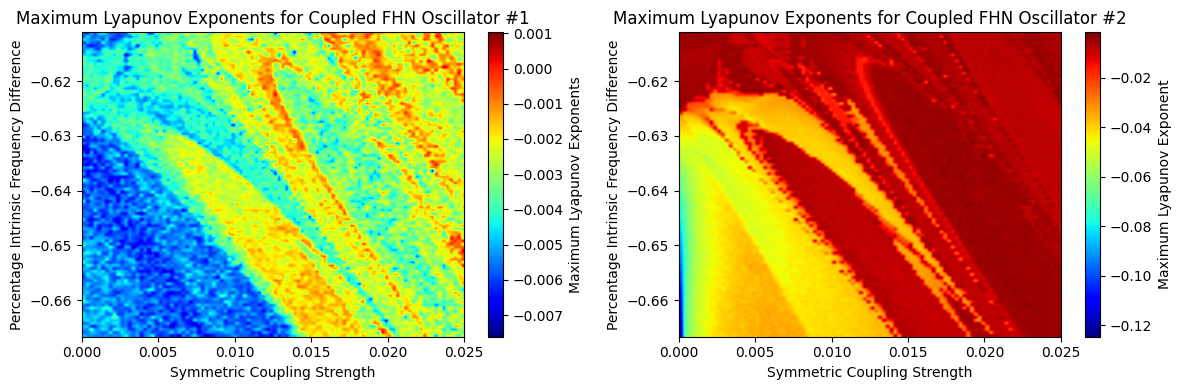

In [7]:
def delays(data, m, J): #create a definition that creates the delayed trajectories for the calculation of lyapunov exponents
    N = len(data)
    M = N - (m-1)*J #relation extracted from paper 
    reconstructed_trajectory = np.zeros((M, m)) #an area of empty trajectories 
    for i in range(m):#for each embedding dimension (3), shift the x value data with the calculated lag (via autocorrelation)
        reconstructed_trajectory[:, i] = data[i*J : i*J + M]
    return reconstructed_trajectory #a matrix with the three reconstructed trajectories, each shifted

#effectively changes the intial conditions, so you can observe chaos with the new conditions 

#use the same code as the R-index to find the k and c values, re-using this so this block can be run individually
k_values = np.linspace(-0.35, -0.3, 100)
c_values = np.linspace(0,0.025,100)
k1 = -0.9 #approximately the maximum
t_span = (0, 100) #Look at larger time solution to notice more potentially chaotic events
y0 = [0, 0, 0, 0]
zeros1 = np.zeros((len(k_values),len(c_values))) #zero areas for the first oscillator 
zeros2 = np.zeros((len(k_values),len(c_values))) #second oscillator 
y_ax_list = []
for k in k_values:
    k2 = k
    dk = k2 - k1
    y_ax_list.append(dk/k1)
y_ax_list.sort()

m = 2 #based on dim corr (CHANGED)
J = 20 #used autocorrelation code below to find lag at exactly (1 - 1/e) of the maximum value
epsilon = 1e-40 #extremely small error added to avoid division by zero

for i in range(len(c_values)): 
    c = c_values[i]
    for j in range(len(y_ax_list)): #of the form dk/k1 
        k = y_ax_list[j]
        k2 = k*k1 + k1
        sol = solve_ivp(fhn_coupled, t_span, y0, method='LSODA', dense_output=True, args=(k1,k2,c))
        xy = sol.y
        x1 = xy[0] #first oscillator solution 
        x2 = xy[2] #second oscillator solution 
        delayed_traj = delays(x1, m, J) #calculate the embedded/delayed trajectories for both oscillators 
        delayed_traj2 = delays(x2, m, J)
        distance1 = np.linalg.norm(delayed_traj[1:,:] - delayed_traj[-1:,:], axis = 1) #calculate the euclidean distance, excluding the first and last values 
        distance1 = distance1 + epsilon #add the error
        distance2 = np.linalg.norm(delayed_traj2[1:,:] - delayed_traj2[-1:,:], axis = 1) #repeat for oscillator
        distance2 = distance2 + epsilon
        t1 = np.linspace(t_span[0], t_span[-1], len(distance1))
        t2 = np.linspace(t_span[0], t_span[-1], len(distance2))
        lyap1 = np.polyfit(t1, np.log(distance1), 1)[0] #fit the logarithm of euclidean distances to time and extact the slope (lyapunov exponent)
        lyap2 = np.polyfit(t2, np.log(distance2), 1)[0]
        zeros1[j,i] = lyap1 #update the empty matrix with maximum lyapunov exponent at that time
        zeros2[j,i] = lyap2


# Plot both responses and label respectively 
#responses were validated with chaotic (selective response of the coupled systems), quasiperiodical (sin), and non choatic (straight line)
#y-axis seems slightly skewed as chaotic systems were demonstraing values greater than zero but with low values
#quasiperiodical response was not quite at zero, likely due to the added error or assumptions made with the LSODA solver

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
# Subplot 1
im1 = axes[0].imshow(zeros1, aspect='auto', extent=[c_values.min(), c_values.max(), min(y_ax_list), max(y_ax_list)],
                     cmap='jet', interpolation='bilinear', origin='lower')
cbar1 = fig.colorbar(im1, ax=axes[0], label='Maximum Lyapunov Exponents')  # Specify colorbar for subplot 1
axes[0].set_title('Maximum Lyapunov Exponents for Coupled FHN Oscillator #1')
axes[0].set_xlabel('Symmetric Coupling Strength')
axes[0].set_ylabel('Percentage Intrinsic Frequency Difference')

# Subplot 2
im2 = axes[1].imshow(zeros2, aspect='auto', extent=[c_values.min(), c_values.max(), min(y_ax_list), max(y_ax_list)],
                     cmap='jet', interpolation='bilinear', origin='lower')
cbar2 = fig.colorbar(im2, ax=axes[1], label='Maximum Lyapunov Exponent')  # Specify colorbar for subplot 2
axes[1].set_title('Maximum Lyapunov Exponents for Coupled FHN Oscillator #2')
axes[1].set_xlabel('Symmetric Coupling Strength')
axes[1].set_ylabel('Percentage Intrinsic Frequency Difference')

plt.tight_layout()
plt.show()

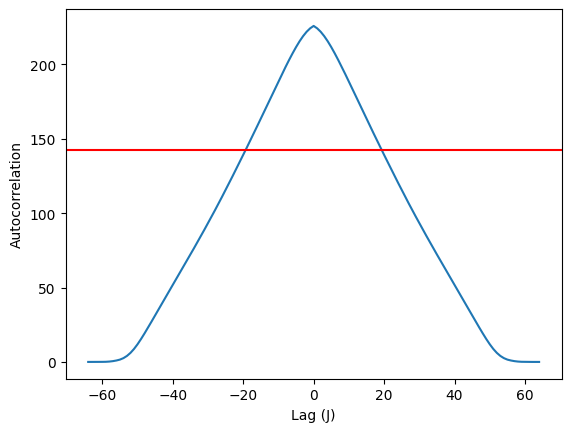

In [24]:
autocorr = np.correlate(x1, x1, mode='full') #calculate autocorrelation 
lag_values = np.arange(-len(x1) + 1, len(x1))

hz = max(autocorr)*(1 - 1 / math.e)
plt.plot(lag_values, autocorr)
plt.axhline(hz, color = 'red')
plt.xlabel('Lag (J)')
plt.ylabel('Autocorrelation')
plt.show()

/Users/peterchimienti97/Desktop/BME1510 Code/myenv/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


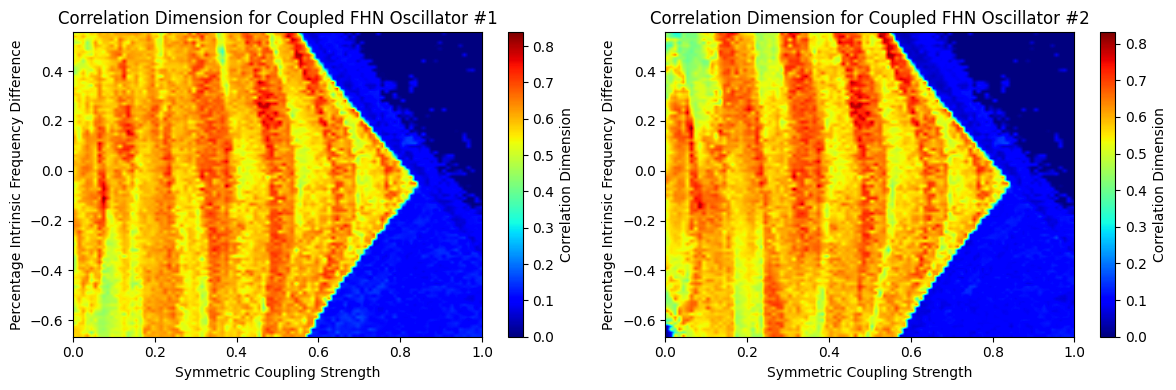

In [30]:
#try not creating a function
#Grassbergers algorthm for computing correlation dimension
#definition to calculate the correlation sum. Calculate the euclidean distance of the embedded trajectories
def correlation_sum(embedded_traj, epsilon): #needs to sum the distances which are less than the corr dimension
    distances = np.linalg.norm(embedded_traj[1:,:] - embedded_traj[-1:,:], axis = 1)
    corr_sum = 0
    for i in range(len(distances) - 1): 
        if (distances[i+1] - distances[i]) < epsilon: #for adjacent pairs, if the difference is less than epsilon, add 1 to the correlation sum
            corr_sum += 1
    return corr_sum
def grassberger_algorithm(embedded_traj, maximum_epsilon):
    epsilon_values = np.logspace(np.log10(0.01), np.log10(maximum_epsilon), 50) #create a logspace of epsilon values 
    correlation_sums = [correlation_sum(embedded_traj, epsilon) for epsilon in epsilon_values] #for each epsilon, calculate and add the correlation sum to the list 
    # Fit a linear relationship to estimate the correlation dimension
    fit_params, _ = curve_fit(lambda x, a, b: a * x + b, epsilon_values, np.log(correlation_sums))
    corr_dimension = fit_params[0] #extract the slope and return it
    return corr_dimension

k_values = np.linspace(-1.4, -0.3, 100);
c_values = np.linspace(0, 1, 100);
k1 = -0.9 #approximately the maximum
t_span = (0, 100)
y0 = [0, 0, 0, 0]
zeros1_1 = np.zeros((len(k_values),len(c_values))) #zero areas for the first oscillator 
zeros2_1 = np.zeros((len(k_values),len(c_values))) #second oscillator 
y_ax_list = []
for k in k_values:
    k2 = k
    dk = k2 - k1
    y_ax_list.append(dk/k1)
y_ax_list.sort()


#using same y_ax as before so no need for loop
m = 3
J = 20
max_epsilon = 1.0 #logspace between 0 and 1

for i in range(len(c_values)): 
    c = c_values[i]
    for j in range(len(y_ax_list)): #of the form dk/k1 
        k = y_ax_list[j]
        k2 = k*k1 + k1
        #fhn_coupled = lambda t, xy: fhn_coupled(t, xy, k1, k2, c) 
        sol = solve_ivp(fhn_coupled, t_span, y0, method='LSODA', dense_output=True, args=(k1,k2,c))
        #t = np.linspace(t_span[0], t_span[1], 1000)
        xy = sol.y
        x1 = xy[0] #m? 
        x2 = xy[2] #n? 
        delayed_traj1 = delays(x1, m, J) #calculate the embedded trajectories
        delayed_traj2 = delays(x2, m, J)
        corr_dim1 = grassberger_algorithm(delayed_traj1, max_epsilon) #use grassberger algorithm to find correlation dimension
        corr_dim2 = grassberger_algorithm(delayed_traj2, max_epsilon)
        zeros1_1[j,i] = corr_dim1 #update the zeros with the correlation dimension corresponding to the right oscillator
        zeros2_1[j,i] = corr_dim2
 
#PLOT!
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
# Subplot 1
im1 = axes[0].imshow(zeros1_1, aspect='auto', extent=[c_values.min(), c_values.max(), min(y_ax_list), max(y_ax_list)],
                     cmap='jet', interpolation='bilinear', origin='lower')
cbar1 = fig.colorbar(im1, ax=axes[0], label='Correlation Dimension')  # Specify colorbar for subplot 1
axes[0].set_title('Correlation Dimension for Coupled FHN Oscillator #1')
axes[0].set_xlabel('Symmetric Coupling Strength')
axes[0].set_ylabel('Percentage Intrinsic Frequency Difference')

# Subplot 2
im2 = axes[1].imshow(zeros2_1, aspect='auto', extent=[c_values.min(), c_values.max(), min(y_ax_list), max(y_ax_list)],
                     cmap='jet', interpolation='bilinear', origin='lower')
cbar2 = fig.colorbar(im2, ax=axes[1], label='Correlation Dimension')  # Specify colorbar for subplot 2
axes[1].set_title('Correlation Dimension for Coupled FHN Oscillator #2')
axes[1].set_xlabel('Symmetric Coupling Strength')
axes[1].set_ylabel('Percentage Intrinsic Frequency Difference')

plt.tight_layout()
plt.show()

[(-0.797979797979798, -0.06172839506172842), (-0.6767676767676767, -0.1975308641975309), (-0.6565656565656566, -0.23456790123456792), (-0.6363636363636364, -0.18518518518518526), (-0.6363636363636364, -0.1728395061728395), (-0.6363636363636364, -0.1358024691358025), (-0.6363636363636364, -0.06172839506172842), (-0.6363636363636364, -0.04938271604938278), (-0.6363636363636364, -0.03703703703703703), (-0.5757575757575757, -0.5185185185185185), (-0.5555555555555556, -0.5802469135802469), (-0.5151515151515151, -0.40740740740740744), (-0.4949494949494949, -0.4320987654320988), (-0.4949494949494949, -0.20987654320987653), (-0.4747474747474747, -0.5802469135802469), (-0.4747474747474747, -0.5555555555555556), (-0.4747474747474747, -0.345679012345679), (-0.4747474747474747, -0.29629629629629634), (-0.4747474747474747, -0.2839506172839506), (-0.4747474747474747, -0.20987654320987653), (-0.4747474747474747, -0.1975308641975309), (-0.4747474747474747, -0.09876543209876545), (-0.4747474747474747, 

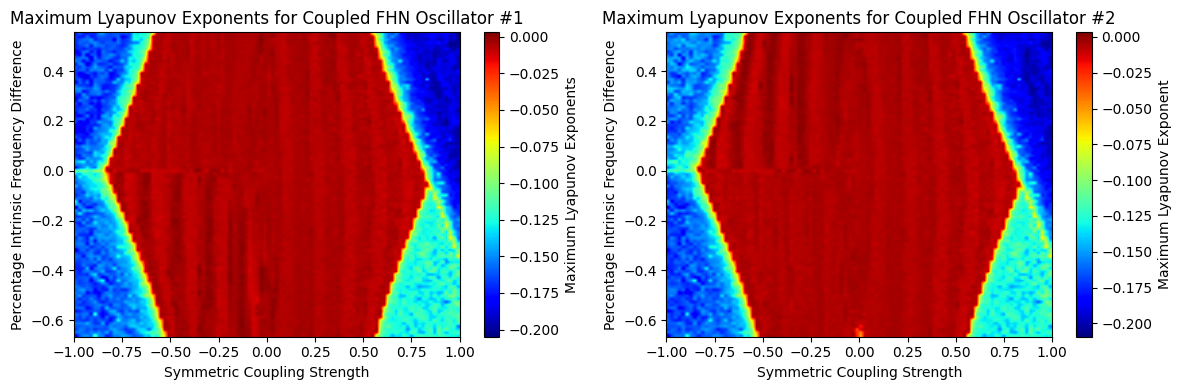

In [85]:
def delays(data, m, J): #create a definition that creates the delayed trajectories for the calculation of lyapunov exponents
    N = len(data)
    M = N - (m-1)*J #relation extracted from paper 
    reconstructed_trajectory = np.zeros((M, m)) #an area of empty trajectories 
    for i in range(m):#for each embedding dimension (3), shift the x value data with the calculated lag (via autocorrelation)
        reconstructed_trajectory[:, i] = data[i*J : i*J + M]
    return reconstructed_trajectory #a matrix with the three reconstructed trajectories, each shifted

#effectively changes the intial conditions, so you can observe chaos with the new conditions 

#use the same code as the R-index to find the k and c values, re-using this so this block can be run individually
k_values = np.linspace(-1.4, -0.3, 100)
c_values = np.linspace(-1, 1, 100)
k1 = -0.9 #approximately the maximum
t_span = (0, 100) #Look at larger time solution to notice more potentially chaotic events
y0 = [0, 0, 0, 0]
zeros1 = np.zeros((len(k_values),len(c_values))) #zero areas for the first oscillator 
zeros2 = np.zeros((len(k_values),len(c_values))) #second oscillator 
y_ax_list = []
for k in k_values:
    k2 = k
    dk = k2 - k1
    y_ax_list.append(dk/k1)
y_ax_list.sort()

high_list = []
m = 1 #based on dim corr (CHANGED)
J = 20 #used autocorrelation code below to find lag at exactly (1 - 1/e) of the maximum value
epsilon = 1e-40 #extremely small error added to avoid division by zero

for i in range(len(c_values)): 
    c = c_values[i]
    for j in range(len(y_ax_list)): #of the form dk/k1 
        k = y_ax_list[j]
        k2 = k*k1 + k1
        sol = solve_ivp(fhn_coupled, t_span, y0, method='LSODA', dense_output=True, args=(k1,k2,c))
        xy = sol.y
        x1 = xy[0] #first oscillator solution 
        x2 = xy[2] #second oscillator solution 
        delayed_traj = delays(x1, m, J) #calculate the embedded/delayed trajectories for both oscillators 
        delayed_traj2 = delays(x2, m, J)
        distance1 = np.linalg.norm(delayed_traj[1:,:] - delayed_traj[-1:,:], axis = 1) #calculate the euclidean distance, excluding the first and last values 
        distance1 = distance1 + epsilon #add the error
        distance2 = np.linalg.norm(delayed_traj2[1:,:] - delayed_traj2[-1:,:], axis = 1) #repeat for oscillator
        distance2 = distance2 + epsilon
        t1 = np.linspace(t_span[0], t_span[-1], len(distance1))
        t2 = np.linspace(t_span[0], t_span[-1], len(distance2))
        lyap1 = np.polyfit(t1, np.log(distance1), 1)[0] #fit the logarithm of euclidean distances to time and extact the slope (lyapunov exponent)
        lyap2 = np.polyfit(t2, np.log(distance2), 1)[0]
        zeros1[j,i] = lyap1 #update the empty matrix with maximum lyapunov exponent at that time
        zeros2[j,i] = lyap2
        if lyap1 > 0: 
            high_list.append((c,k))

print(high_list)


# Plot both responses and label respectively 
#responses were validated with chaotic (selective response of the coupled systems), quasiperiodical (sin), and non choatic (straight line)
#y-axis seems slightly skewed as chaotic systems were demonstraing values greater than zero but with low values
#quasiperiodical response was not quite at zero, likely due to the added error or assumptions made with the LSODA solver

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
# Subplot 1
im1 = axes[0].imshow(zeros1, aspect='auto', extent=[c_values.min(), c_values.max(), min(y_ax_list), max(y_ax_list)],
                     cmap='jet', interpolation='bilinear', origin='lower')
cbar1 = fig.colorbar(im1, ax=axes[0], label='Maximum Lyapunov Exponents')  # Specify colorbar for subplot 1
axes[0].set_title('Maximum Lyapunov Exponents for Coupled FHN Oscillator #1')
axes[0].set_xlabel('Symmetric Coupling Strength')
axes[0].set_ylabel('Percentage Intrinsic Frequency Difference')

# Subplot 2
im2 = axes[1].imshow(zeros2, aspect='auto', extent=[c_values.min(), c_values.max(), min(y_ax_list), max(y_ax_list)],
                     cmap='jet', interpolation='bilinear', origin='lower')
cbar2 = fig.colorbar(im2, ax=axes[1], label='Maximum Lyapunov Exponent')  # Specify colorbar for subplot 2
axes[1].set_title('Maximum Lyapunov Exponents for Coupled FHN Oscillator #2')
axes[1].set_xlabel('Symmetric Coupling Strength')
axes[1].set_ylabel('Percentage Intrinsic Frequency Difference')

plt.tight_layout()
plt.show()

-0.36


<Figure size 640x480 with 0 Axes>

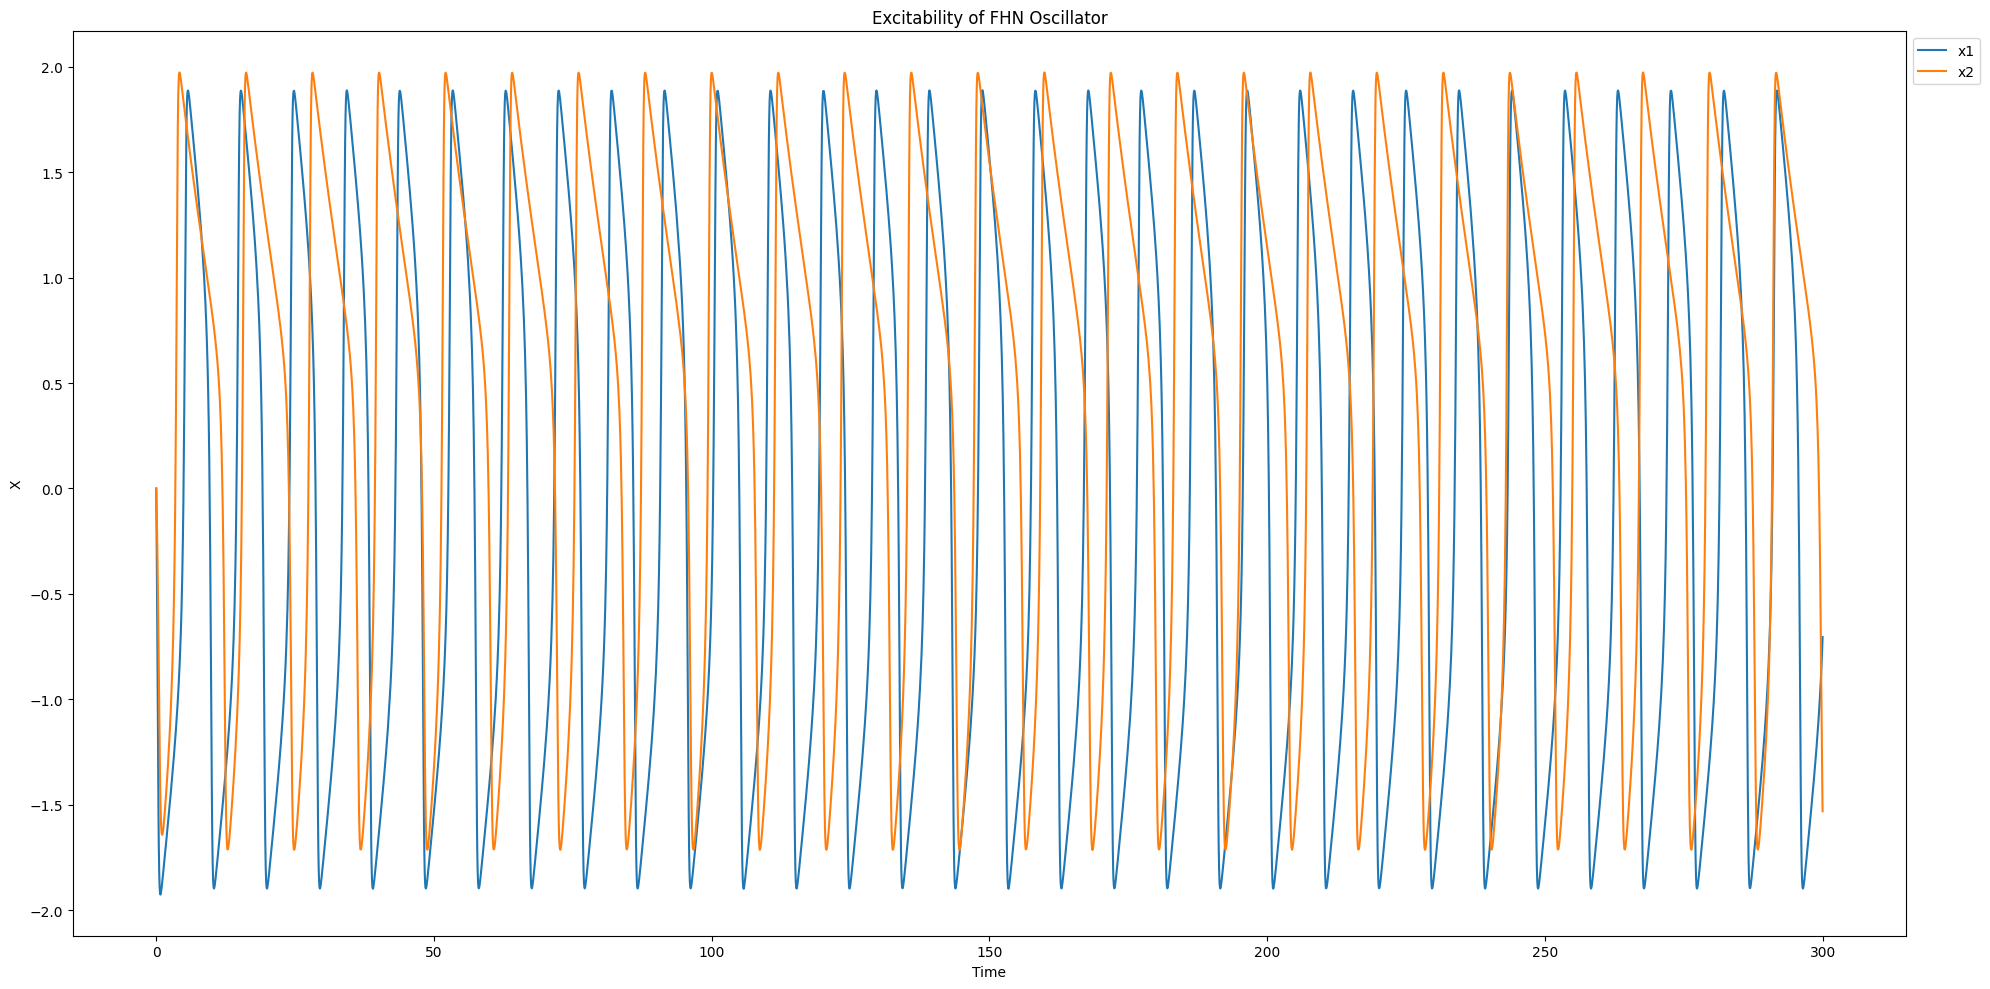

In [16]:
#PLAY AROUND WITH THE COUPLED SYSTEM GRAPHS & VALIDATION!!
#This block of code is used to observed the behaviour of the coupled responses for set k1 and k2 values
#can validate the R-index, Lyapunov, and Correlation Dimension

t_span = (0, 300) #change to 1000
y0 = [0,0,0,0] #change 
plt.figure()

k1 = -0.9
k =  -0.6
k2 = k*k1 + k1
print(k2)
c = 0
sol = solve_ivp(fhn_coupled, t_span, y0, method='LSODA', dense_output=True, args=(k1,k2,c))

xy = sol.y
t = sol.t
x1 = xy[0]
x2 = xy[2]

# Set the figure size
plt.figure(figsize=(20, 10))

# Plot x1 with label 'x1'
plt.plot(t, x1, label='x1')

# Plot x2 with label 'x2'
plt.plot(t, x2, label='x2')

plt.xlabel('Time')
plt.ylabel('X')
plt.title('Excitability of FHN Oscillator')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()